In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## Finding the optimised loan amount

In [ ]:
df = pd.read_csv('credit_risk_dataset.csv')

In [ ]:
import pickle

with open("loan_xgboost3.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
def binary_search_approved(user_input, model, min_amt=200, max_amt=500):

    user_input = user_input.copy()
    user_input.pop("Index", None)

    left, right = min_amt, max_amt
    best = None

    while left <= right:
        mid = (left + right) // 2
        temp = user_input.copy()
        temp["loan_amnt"] = mid
        temp["loan_percent_income"] = mid / temp["person_income"]

        input_df = pd.DataFrame([temp])

        # Drop extra columns that aren't part of model input
        if "loan_amnt_optimised" in input_df.columns:
            input_df = input_df.drop(columns=["loan_amnt_optimised"])
        if "loan_status" in input_df.columns:
            input_df = input_df.drop(columns=["loan_status"])

        pred = model.predict(input_df)[0]

        if pred == 0:
            best = mid
            left = mid + 1
        else:
            right = mid - 1
    return best

In [ ]:
from tqdm import tqdm

# Initialize the new column with None
df["loan_amnt_optimised"] = None

# Apply only to first 10 rows
for idx, row in tqdm(df.iloc[:10].iterrows(), total=10):
    user_input = row.to_dict()

    if row["loan_status"] == 0:
        # Already approved, keep original amount
        df.at[idx, "loan_amnt_optimised"] = row["loan_amnt"]
    else:
        # Try to find max approved amount for this rejected application
        max_approved = binary_search_approved(
            user_input, model, min_amt=200, max_amt=int(row["loan_amnt"])
        )
        df.at[idx, "loan_amnt_optimised"] = max_approved if max_approved is not None else 0

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv("optimized_loans.csv", index=False)

## Exploratory Data Analysis

In [21]:
# Load dataset
df = pd.read_csv('optimized_loans.csv')

In [22]:
print("Dataset shape:", df.shape)

Dataset shape: (32572, 21)


In [79]:
df.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_amnt_optimised
0,21,9600.0,5.0,1,1000,11.14,0,0.104167,0,2,...,0,1,0,0,1,0,0,0,0,1000.0
1,25,9600.0,1.0,2,5500,12.87,1,0.572917,0,3,...,0,0,0,0,0,0,1,0,0,1476.0
2,23,65500.0,4.0,2,35000,15.23,1,0.534351,0,2,...,0,0,1,0,0,0,1,0,0,19934.0
3,24,54400.0,8.0,2,35000,14.27,1,0.643382,1,4,...,0,0,1,0,0,0,1,0,0,16556.0
4,21,9900.0,2.0,0,2500,7.14,1,0.252525,0,2,...,0,1,0,0,0,0,0,0,1,1523.0


In [23]:
print("\nData Types:")
print(df.dtypes)


Data Types:
person_age                          int64
person_income                     float64
person_emp_length                 float64
loan_grade                          int64
loan_amnt                           int64
loan_int_rate                     float64
loan_status                         int64
loan_percent_income               float64
cb_person_default_on_file           int64
cb_person_cred_hist_length          int64
person_home_ownership_MORTGAGE      int64
person_home_ownership_OTHER         int64
person_home_ownership_OWN           int64
person_home_ownership_RENT          int64
loan_intent_DEBTCONSOLIDATION       int64
loan_intent_EDUCATION               int64
loan_intent_HOMEIMPROVEMENT         int64
loan_intent_MEDICAL                 int64
loan_intent_PERSONAL                int64
loan_intent_VENTURE                 int64
loan_amnt_optimised               float64
dtype: object


In [24]:
print("\nSummary Statistics for Target Variable:")
print(df['loan_amnt_optimised'].describe())


Summary Statistics for Target Variable:
count    32572.000000
mean      8439.087284
std       6295.042462
min        200.000000
25%       4000.000000
50%       7200.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt_optimised, dtype: float64


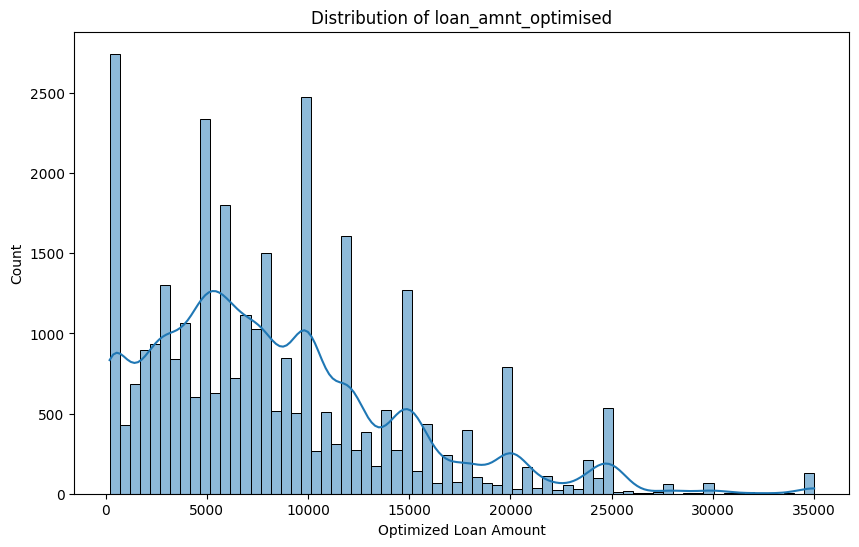

In [25]:
# Visualizing the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_amnt_optimised'], kde=True)
plt.title('Distribution of loan_amnt_optimised')
plt.xlabel('Optimized Loan Amount')
plt.show()

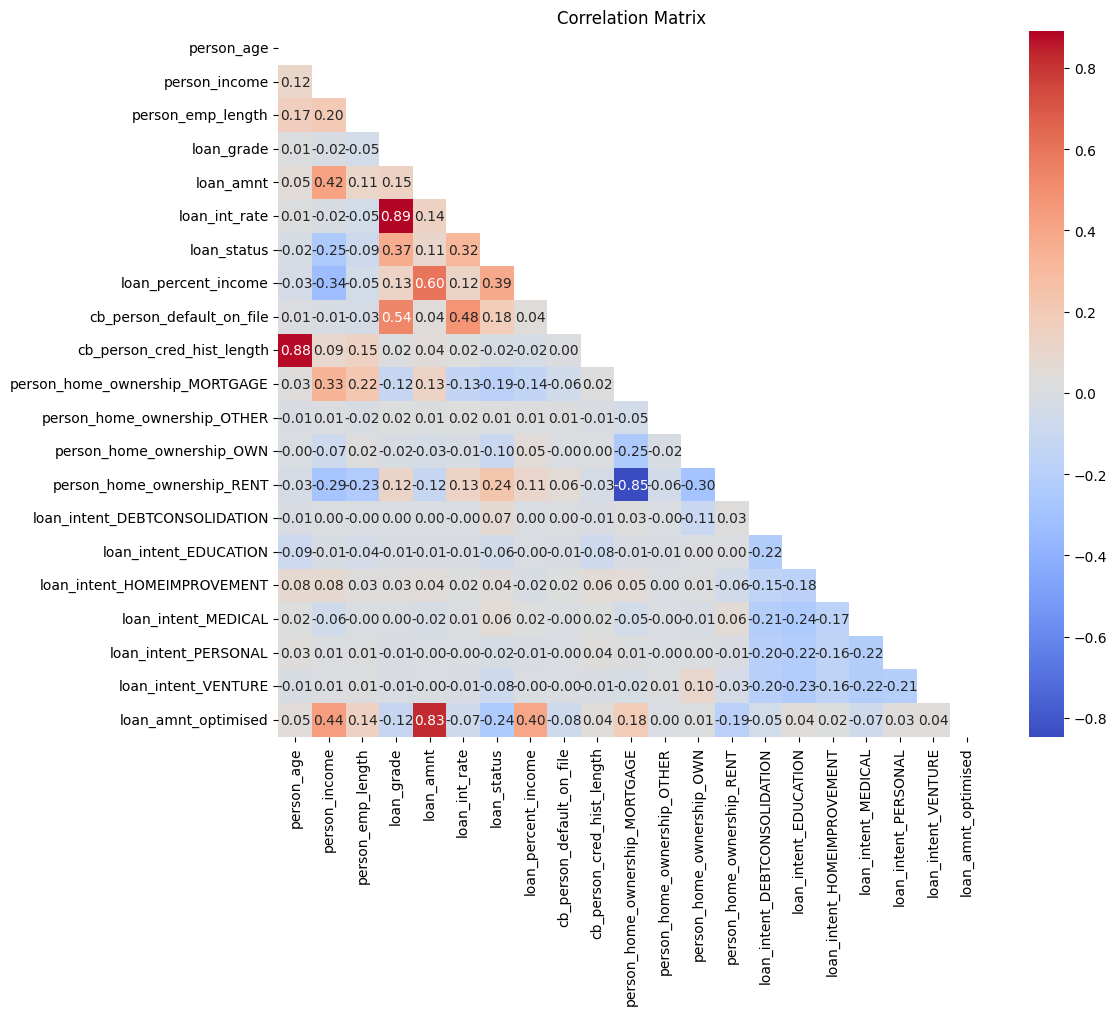

In [26]:
# Checking for correlations with target variable
plt.figure(figsize=(12, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()

In [27]:
# Print top correlations with target
correlations = corr['loan_amnt_optimised'].sort_values(ascending=False)
print("\nTop correlations with loan_amnt_optimised:")
print(correlations)


Top correlations with loan_amnt_optimised:
loan_amnt_optimised               1.000000
loan_amnt                         0.826130
person_income                     0.439681
loan_percent_income               0.400860
person_home_ownership_MORTGAGE    0.184748
person_emp_length                 0.141728
person_age                        0.045886
cb_person_cred_hist_length        0.037266
loan_intent_EDUCATION             0.036190
loan_intent_VENTURE               0.036073
loan_intent_PERSONAL              0.029197
loan_intent_HOMEIMPROVEMENT       0.020790
person_home_ownership_OWN         0.011288
person_home_ownership_OTHER       0.001257
loan_intent_DEBTCONSOLIDATION    -0.051945
loan_intent_MEDICAL              -0.068254
loan_int_rate                    -0.070520
cb_person_default_on_file        -0.078815
loan_grade                       -0.115944
person_home_ownership_RENT       -0.188161
loan_status                      -0.239934
Name: loan_amnt_optimised, dtype: float64


## data preprcoessing

In [28]:
features = df.drop(['loan_amnt_optimised', 'loan_status'], axis=1)
target = df['loan_amnt_optimised']

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [30]:
# Feature scaling
scaler = StandardScaler()
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_grade', 'loan_amnt',
                        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
    
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [38]:
# Function to evaluate regression model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Scatter plot of predicted vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Loan Amount')
    plt.ylabel('Predicted Loan Amount')
    plt.title(f'Actual vs Predicted Loan Amounts - {model_name}')
    plt.show()
    
    return {
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

In [40]:
# Feature importance analysis
def plot_feature_importance(model, X_train, model_name):
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Features:")
        print(feature_importance.head(10))
    
    elif hasattr(model, 'coef_'):
        coefficients = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_
        }).sort_values('Coefficient', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=coefficients)
        plt.title(f'Feature Coefficients - {model_name}')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Features by absolute coefficient value:")
        print(coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(10))

## training model

In [41]:
results = {}


Linear Regression Evaluation:
RMSE: $2967.28
MAE: $1826.55
R² Score: 0.7751


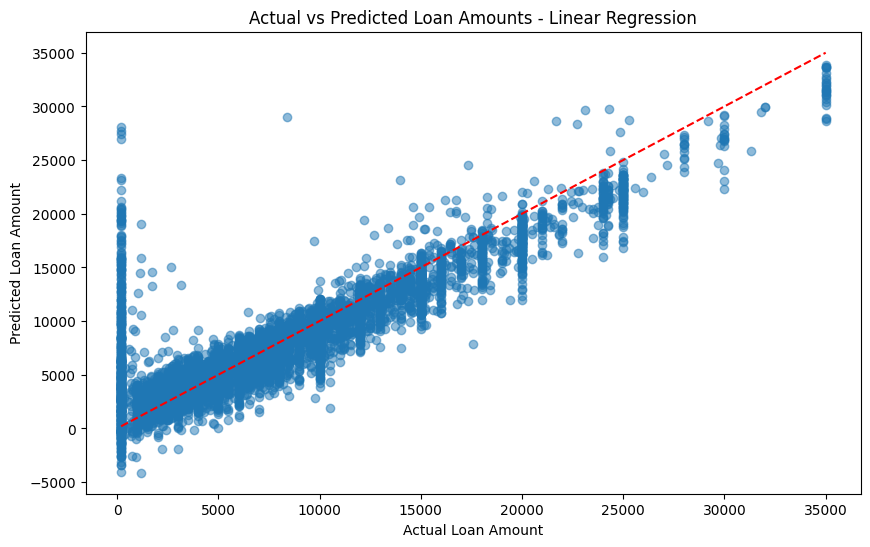

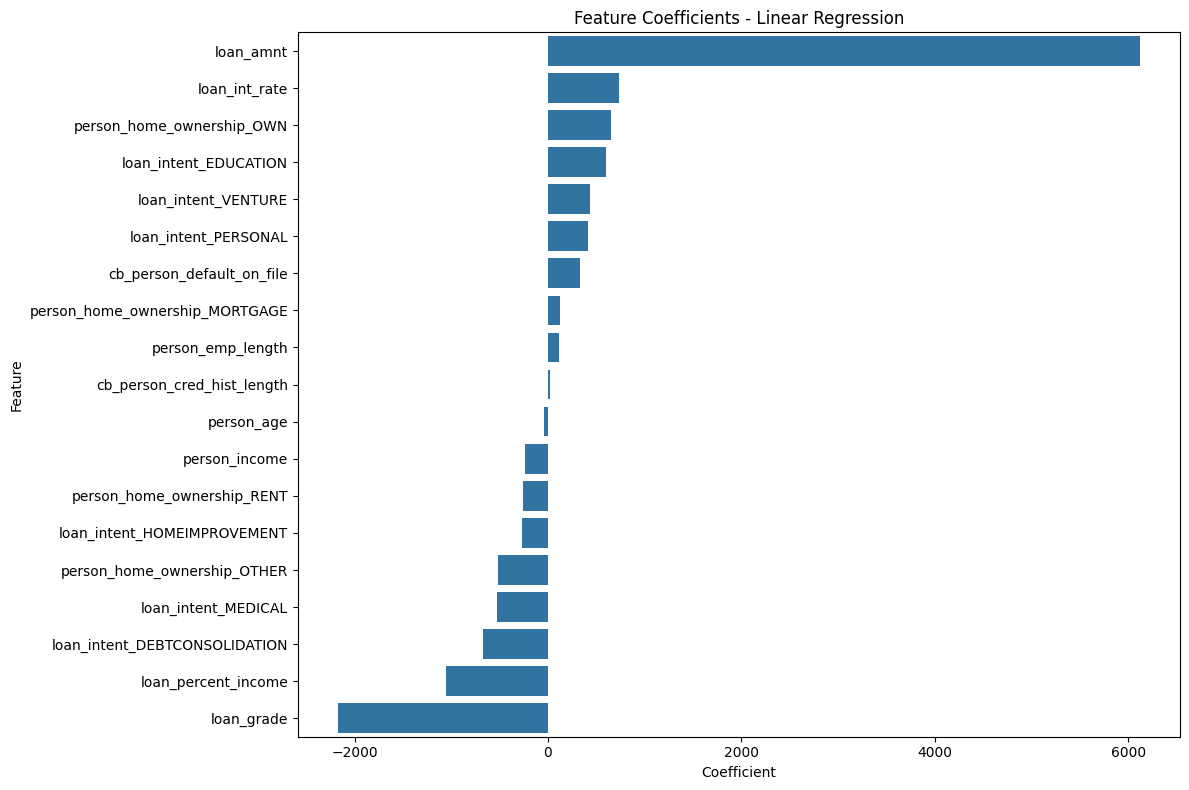


Top 10 Features by absolute coefficient value:
                          Feature  Coefficient
4                       loan_amnt  6120.029102
3                      loan_grade -2169.426920
6             loan_percent_income -1055.396548
5                   loan_int_rate   738.556425
13  loan_intent_DEBTCONSOLIDATION  -666.713102
11      person_home_ownership_OWN   651.508591
14          loan_intent_EDUCATION   604.543256
16            loan_intent_MEDICAL  -527.754009
10    person_home_ownership_OTHER  -514.926703
18            loan_intent_VENTURE   439.355584


In [49]:
# Linera Regression 
model = LinearRegression()
model.fit(X_train, y_train)
result = evaluate_model(model, X_test, y_test, 'Linear Regression')
results['Linear Regression'] = result
plot_feature_importance(model, X_train, 'Linear Regression')


Ridge Regression Evaluation:
RMSE: $2967.29
MAE: $1826.58
R² Score: 0.7751


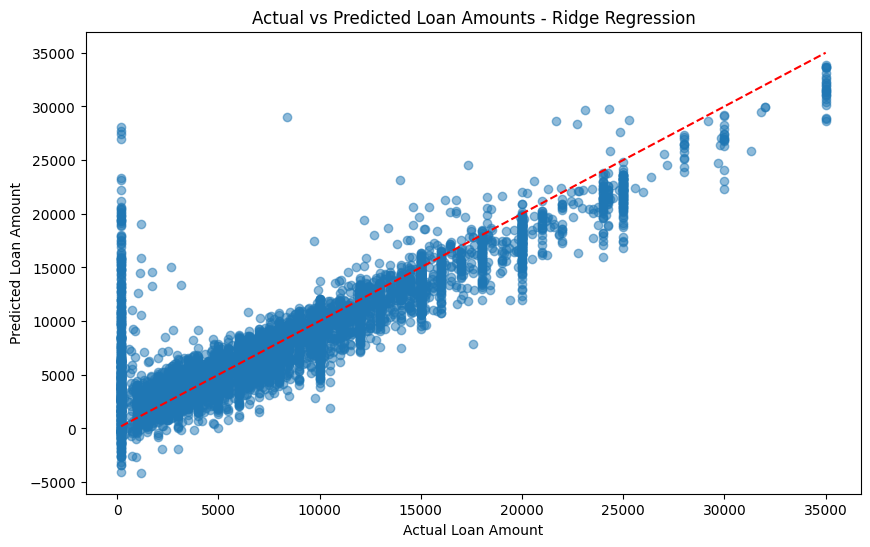

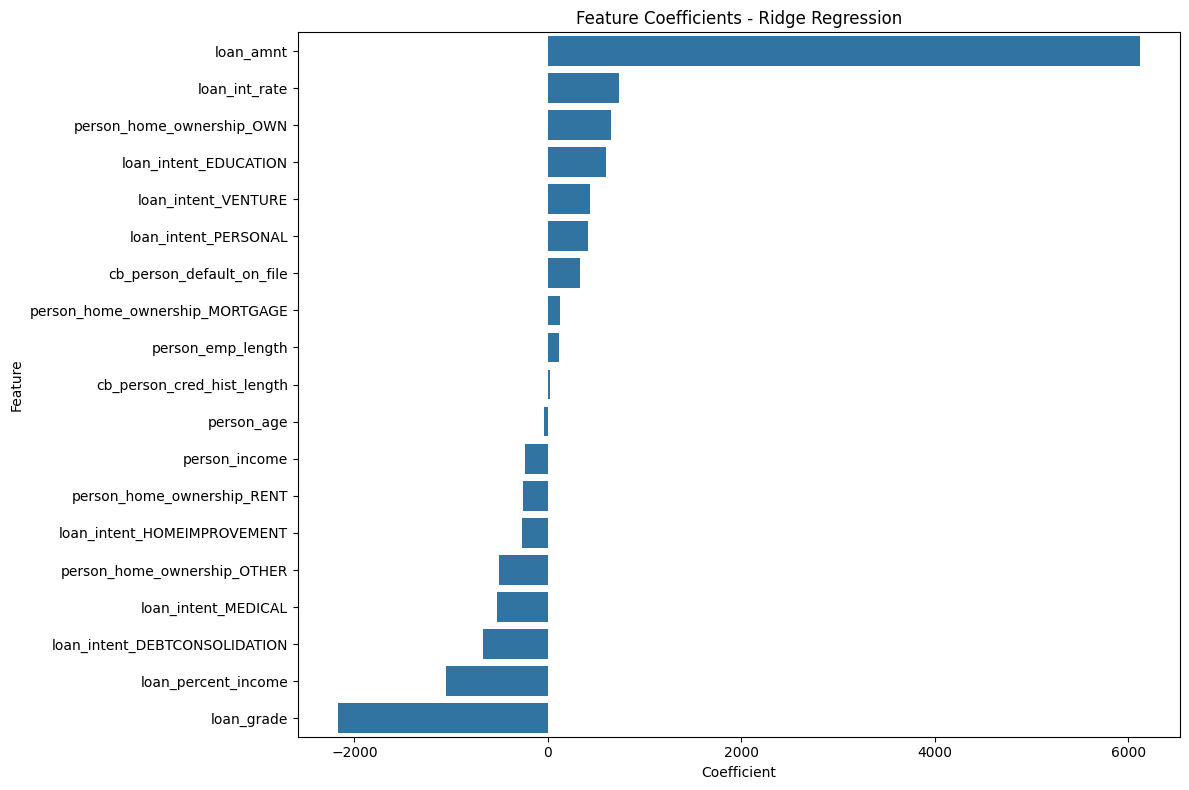


Top 10 Features by absolute coefficient value:
                          Feature  Coefficient
4                       loan_amnt  6118.587747
3                      loan_grade -2168.829331
6             loan_percent_income -1054.164621
5                   loan_int_rate   738.121521
13  loan_intent_DEBTCONSOLIDATION  -666.587340
11      person_home_ownership_OWN   649.820354
14          loan_intent_EDUCATION   604.428649
16            loan_intent_MEDICAL  -527.637296
10    person_home_ownership_OTHER  -510.600879
18            loan_intent_VENTURE   439.247718


In [50]:
# Ridge Regression 
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
result = evaluate_model(model, X_test, y_test, 'Ridge Regression')
results['Ridge Regression'] = result
plot_feature_importance(model, X_train, 'Ridge Regression')


Lasso Regression Evaluation:
RMSE: $2967.29
MAE: $1826.48
R² Score: 0.7751


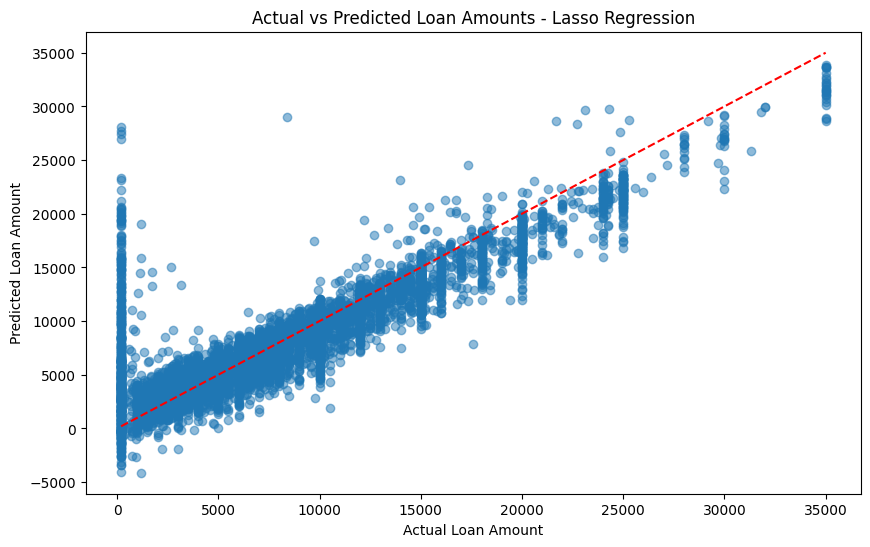

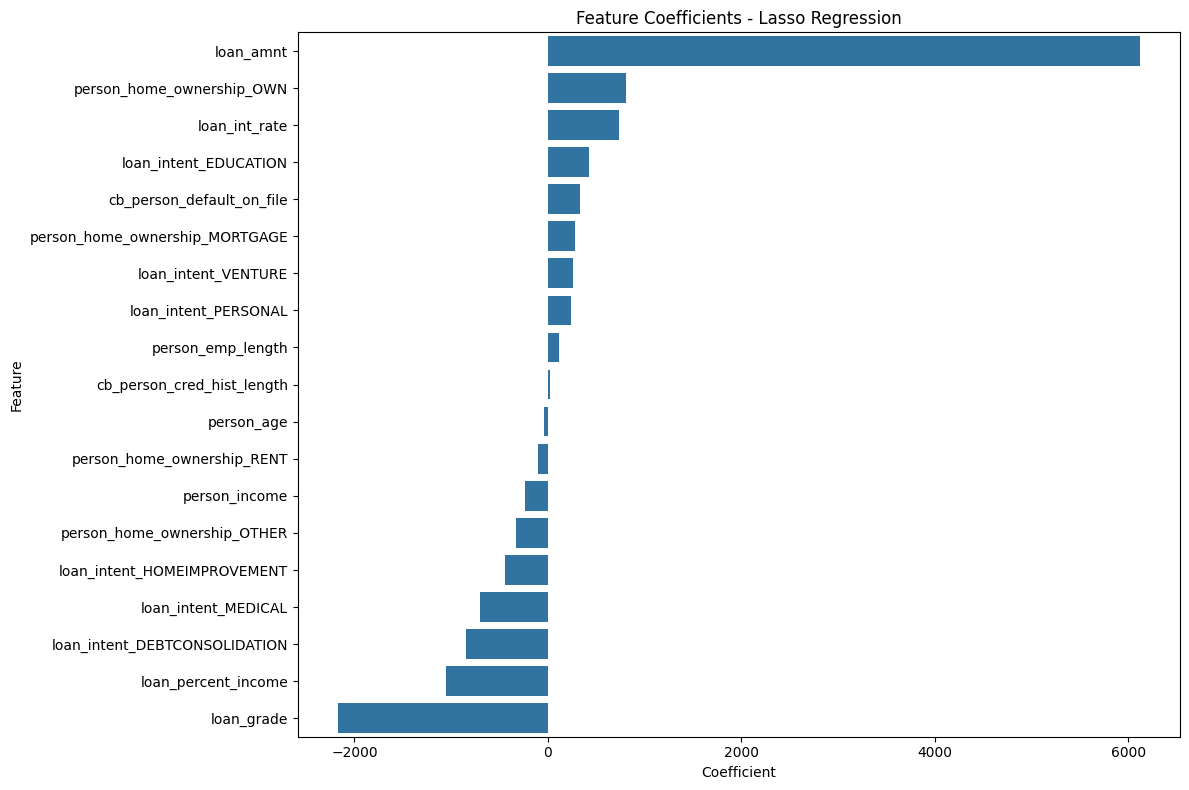


Top 10 Features by absolute coefficient value:
                          Feature  Coefficient
4                       loan_amnt  6118.694209
3                      loan_grade -2168.316184
6             loan_percent_income -1054.183943
13  loan_intent_DEBTCONSOLIDATION  -841.961203
11      person_home_ownership_OWN   805.502147
5                   loan_int_rate   737.678249
16            loan_intent_MEDICAL  -703.001307
15    loan_intent_HOMEIMPROVEMENT  -439.430743
14          loan_intent_EDUCATION   428.284834
10    person_home_ownership_OTHER  -330.512923


In [51]:
# Lasso Regression 
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
result = evaluate_model(model, X_test, y_test, 'Lasso Regression')
results['Lasso Regression'] = result
plot_feature_importance(model, X_train, 'Lasso Regression')


Random Forest Evaluation:
RMSE: $912.08
MAE: $227.07
R² Score: 0.9788


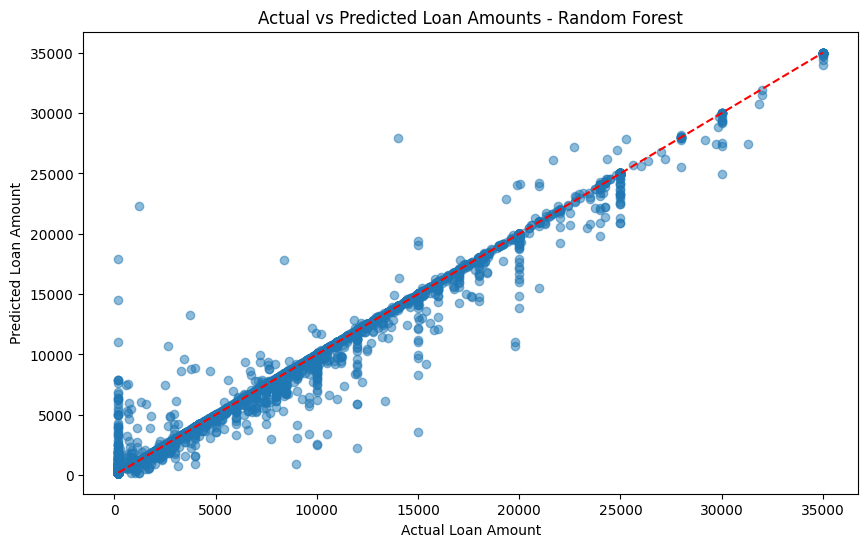

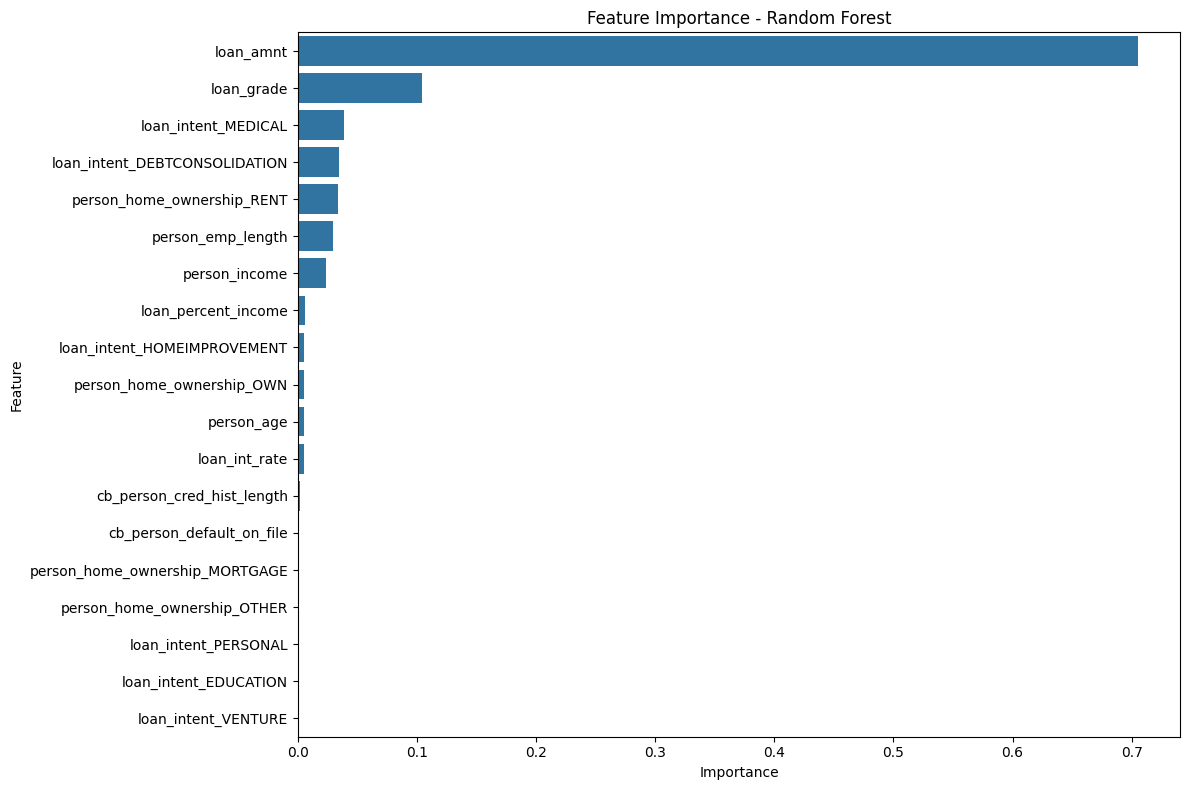


Top 10 Features:
                          Feature  Importance
4                       loan_amnt    0.705347
3                      loan_grade    0.103690
16            loan_intent_MEDICAL    0.038445
13  loan_intent_DEBTCONSOLIDATION    0.034177
12     person_home_ownership_RENT    0.033537
2               person_emp_length    0.029544
1                   person_income    0.023772
6             loan_percent_income    0.006265
15    loan_intent_HOMEIMPROVEMENT    0.005404
11      person_home_ownership_OWN    0.005291


In [52]:
# Random Forest 
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
result = evaluate_model(model, X_test, y_test, 'Random Forest')
results['Random Forest'] = result
plot_feature_importance(model, X_train, 'Random Forest')


Gradient Boosting Evaluation:
RMSE: $1660.22
MAE: $740.69
R² Score: 0.9296


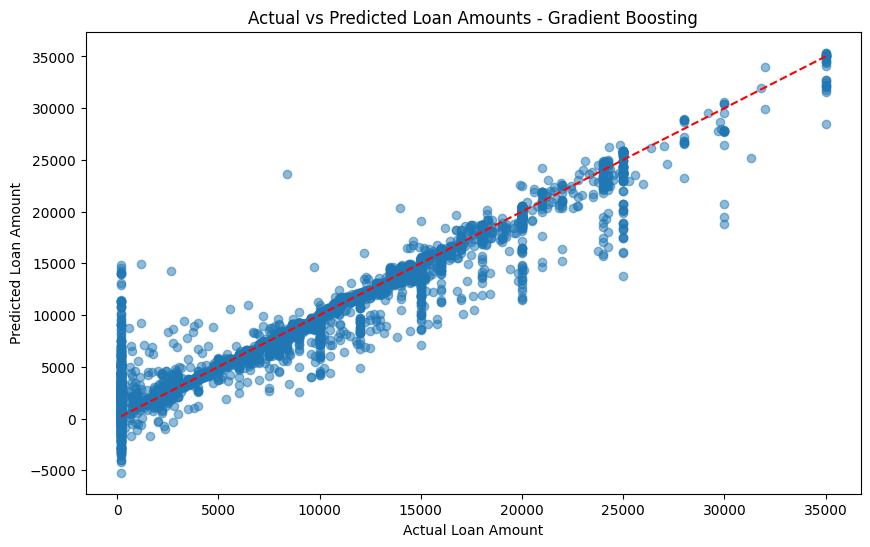

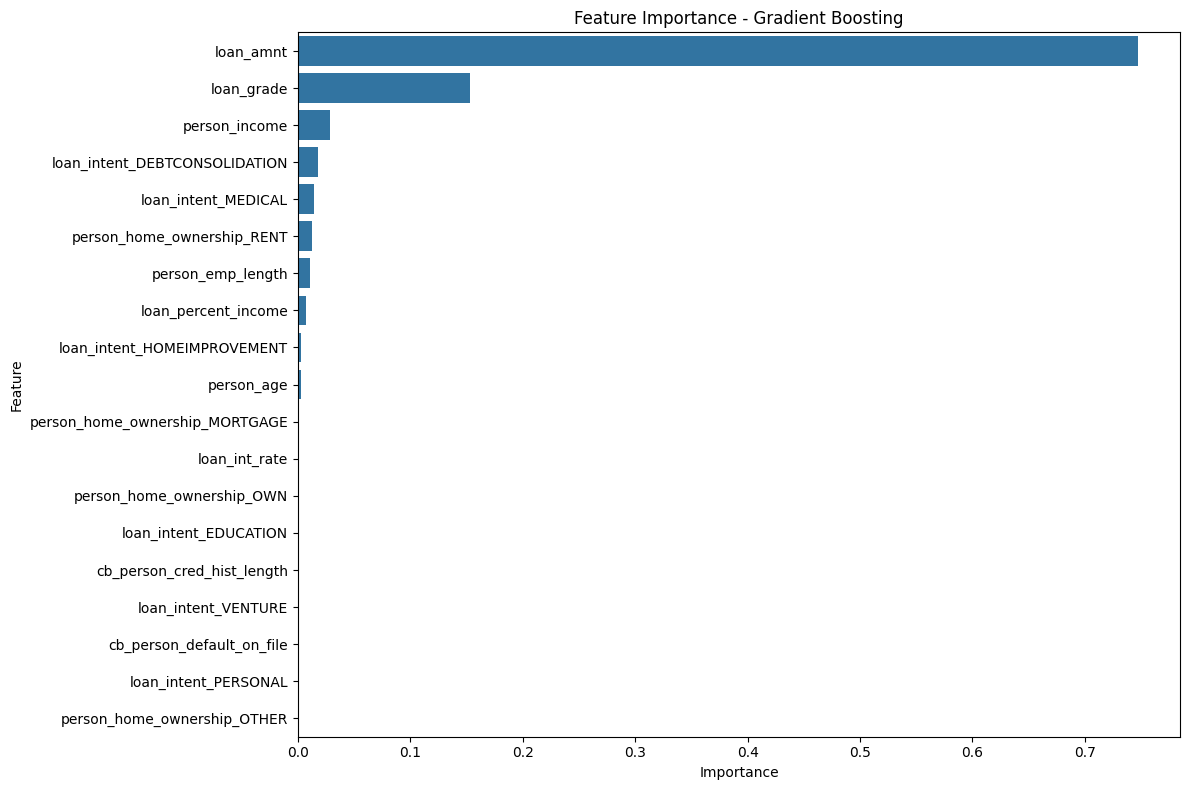


Top 10 Features:
                          Feature  Importance
4                       loan_amnt    0.747360
3                      loan_grade    0.153352
1                   person_income    0.028657
13  loan_intent_DEBTCONSOLIDATION    0.017851
16            loan_intent_MEDICAL    0.014211
12     person_home_ownership_RENT    0.012619
2               person_emp_length    0.010640
6             loan_percent_income    0.007074
15    loan_intent_HOMEIMPROVEMENT    0.002729
0                      person_age    0.002369


In [53]:
# Gradient Boosting 
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
result = evaluate_model(model, X_test, y_test, 'Gradient Boosting')
results['Gradient Boosting'] = result
plot_feature_importance(model, X_train, 'Gradient Boosting')


XGBoost Evaluation:
RMSE: $983.35
MAE: $360.52
R² Score: 0.9753


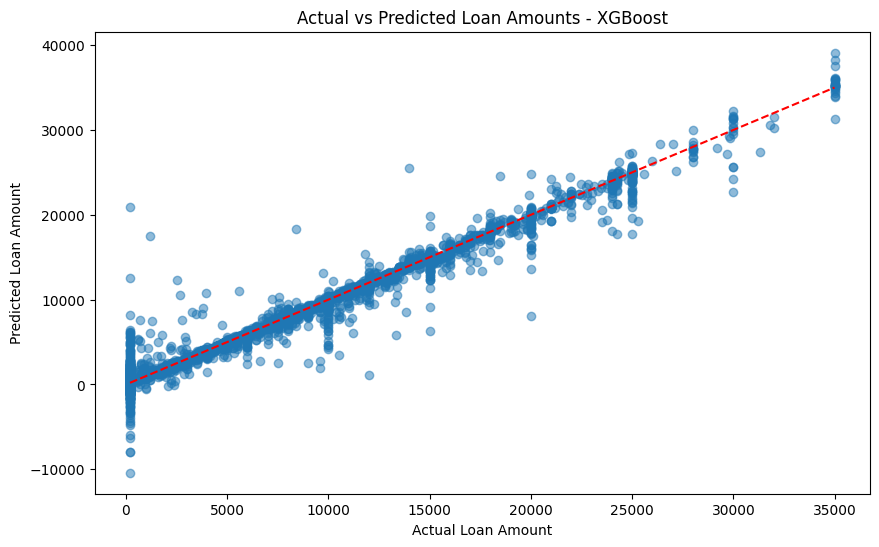

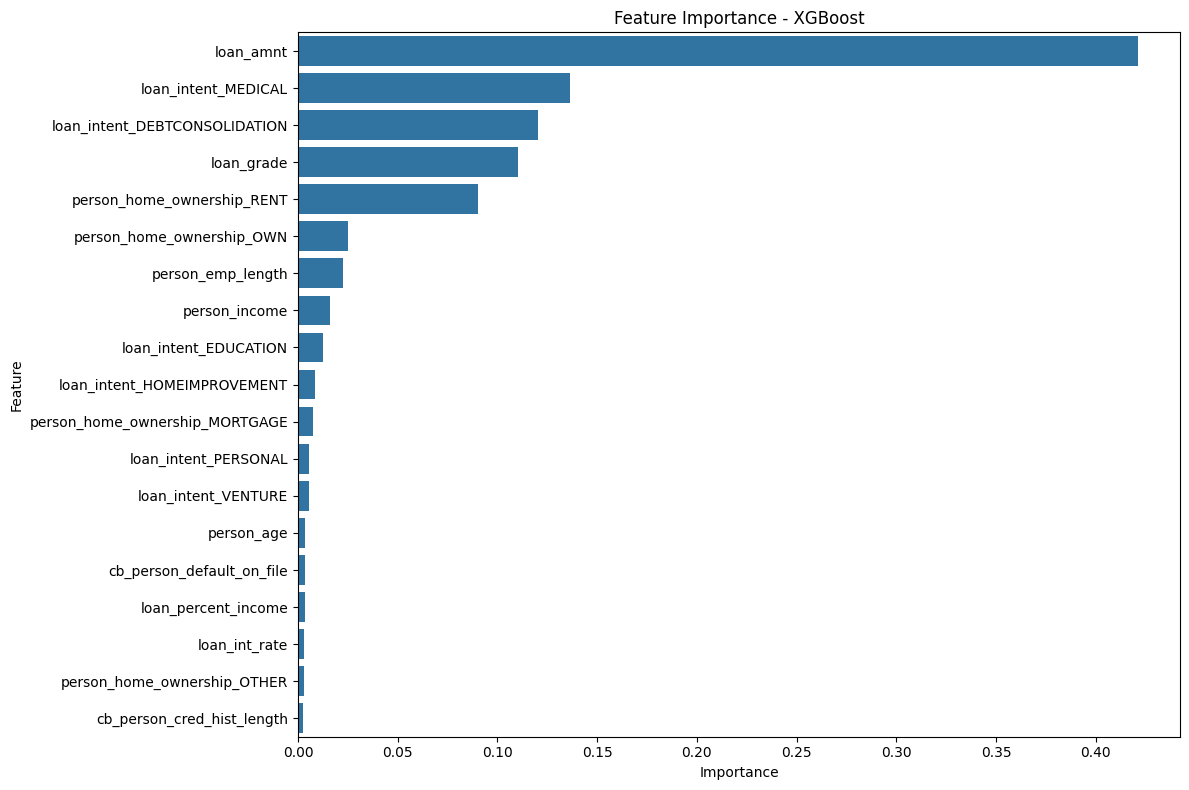


Top 10 Features:
                          Feature  Importance
4                       loan_amnt    0.421227
16            loan_intent_MEDICAL    0.136234
13  loan_intent_DEBTCONSOLIDATION    0.120192
3                      loan_grade    0.110360
12     person_home_ownership_RENT    0.090328
11      person_home_ownership_OWN    0.024834
2               person_emp_length    0.022733
1                   person_income    0.015892
14          loan_intent_EDUCATION    0.012668
15    loan_intent_HOMEIMPROVEMENT    0.008551


In [54]:
# XGBoost 
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
result = evaluate_model(model, X_test, y_test, 'XGBoost')
results['XGBoost'] = result
plot_feature_importance(model, X_train, 'XGBoost')

## Neural Network 

In [56]:
# Neural Network with Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [57]:
# Define the neural network model
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error'
    )
    return model

In [58]:
# Train the neural network model
nn_model = build_nn_model(X_train.shape[1])

In [59]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [60]:
# Train the model
history = nn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 86136208.0000 - val_loss: 11746555.0000
Epoch 2/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12933277.0000 - val_loss: 10646860.0000
Epoch 3/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12336617.0000 - val_loss: 10142975.0000
Epoch 4/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11696200.0000 - val_loss: 9701757.0000
Epoch 5/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11398250.0000 - val_loss: 9512415.0000
Epoch 6/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11015339.0000 - val_loss: 9349710.0000
Epoch 7/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10673015.0000 - val_loss: 9243569.0000
Epoch 8/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10769011.0000 - val_loss: 9191938.0000
Epoch 9/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10842815.0000 - val_loss: 9200006.0000
Epoch 10/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10296740.0000 - val_loss: 9167819.0

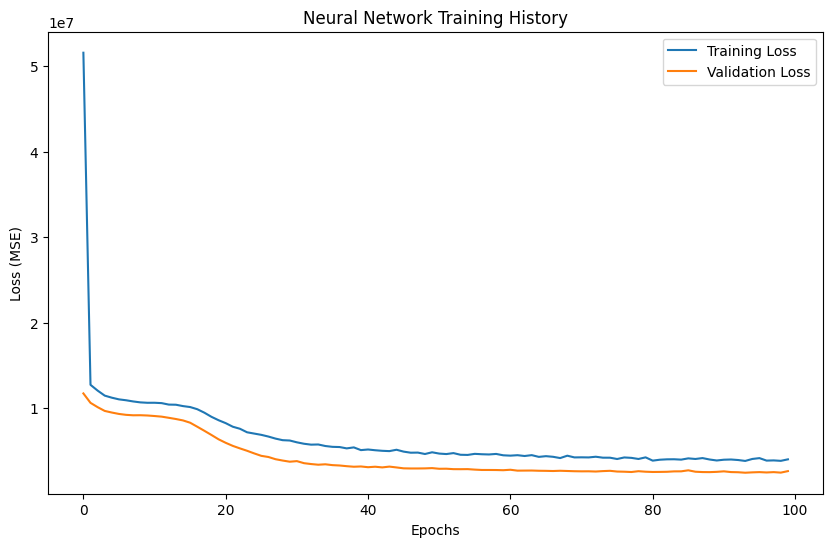

In [61]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step

Neural Network Evaluation:
RMSE: $1499.17
MAE: $749.69
R² Score: 0.9426


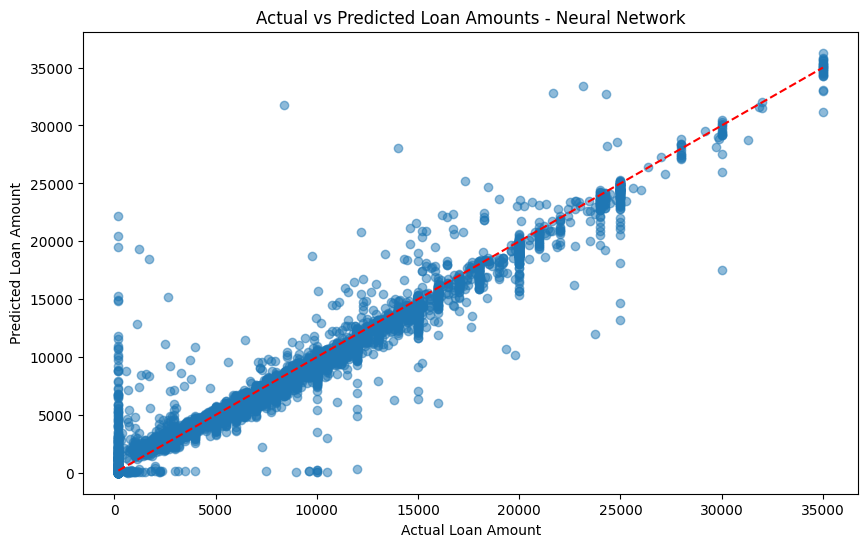

In [62]:
# Evaluate the neural network model
nn_result = evaluate_model(nn_model, X_test, y_test, 'Neural Network')
results['Neural Network'] = nn_result

## Results Analysis 

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the table
model_names = list(results.keys())
rmse_values = [results[model]['rmse'] for model in model_names]
mae_values = [results[model]['mae'] for model in model_names]
r2_values = [results[model]['r2'] for model in model_names]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'RMSE ($)': rmse_values,
    'MAE ($)': mae_values,
    'R² Score': r2_values
})

# Sort the DataFrame by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE ($)', ascending=True).reset_index(drop=True)

# Format the table for better display
formatted_df = comparison_df.copy()
formatted_df['RMSE ($)'] = formatted_df['RMSE ($)'].apply(lambda x: f"${x:.2f}")
formatted_df['MAE ($)'] = formatted_df['MAE ($)'].apply(lambda x: f"${x:.2f}")
formatted_df['R² Score'] = formatted_df['R² Score'].apply(lambda x: f"{x:.4f}")

print("\nModel Performance Comparison:")
print(formatted_df.to_string(index=False))


Model Performance Comparison:
            Model RMSE ($)  MAE ($) R² Score
    Random Forest  $912.08  $227.07   0.9788
          XGBoost  $983.35  $360.52   0.9753
   Neural Network $1499.17  $749.69   0.9426
Gradient Boosting $1660.22  $740.69   0.9296
Linear Regression $2967.28 $1826.55   0.7751
 Ridge Regression $2967.29 $1826.58   0.7751
 Lasso Regression $2967.29 $1826.48   0.7751


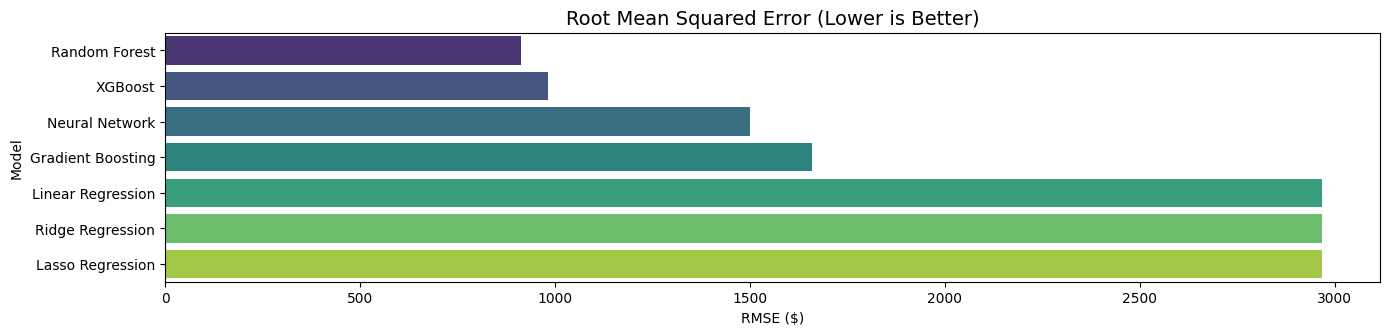

In [71]:
# Plot RMSE
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
sns.barplot(x='RMSE ($)', y='Model', data=comparison_df, palette='viridis')
plt.title('Root Mean Squared Error (Lower is Better)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

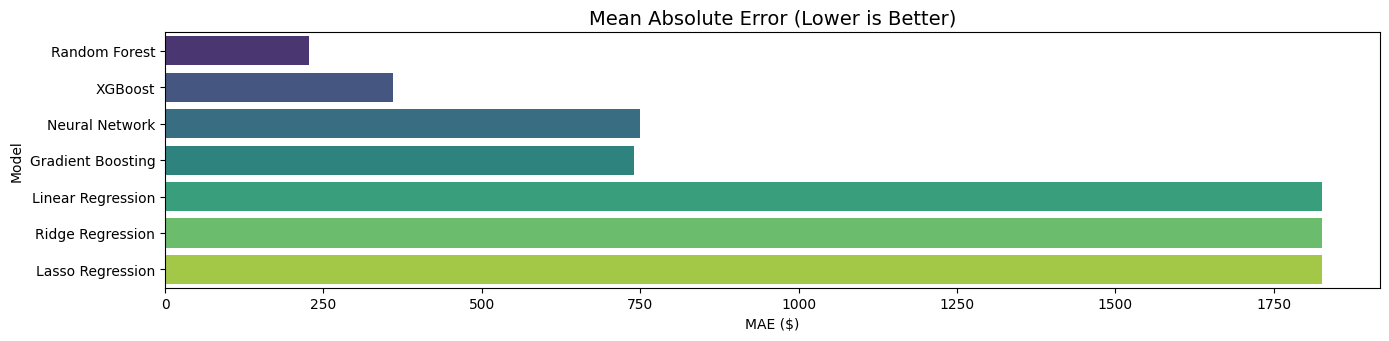

In [72]:
# Plot MAE
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 2)
sns.barplot(x='MAE ($)', y='Model', data=comparison_df, palette='viridis')
plt.title('Mean Absolute Error (Lower is Better)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

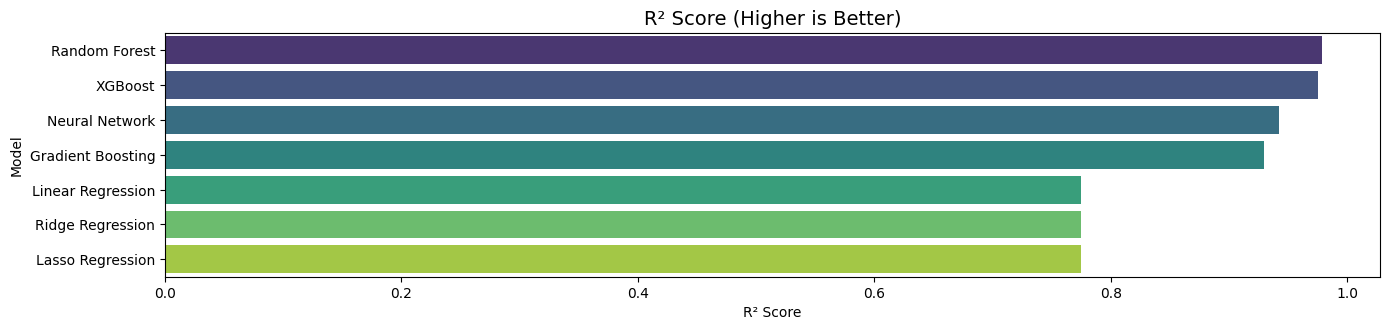

In [74]:
# Plot R²
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 3)
sns.barplot(x='R² Score', y='Model', data=comparison_df, palette='viridis')
plt.title('R² Score (Higher is Better)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [75]:
# Identify the best model
best_model = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE ($)']
best_r2 = comparison_df.iloc[0]['R² Score']

print(f"\nBest Performing Model: {best_model}")
print(f"Best RMSE: ${best_rmse:.2f}")
print(f"Best R² Score: {best_r2:.4f}")
print("\nKey Findings:")
print(f"1. {best_model} achieves the best performance with an RMSE of ${best_rmse:.2f}")
print(f"2. Tree-based models (Random Forest, XGBoost) significantly outperform linear models")
print(f"3. Neural Network performs better than linear models but not as well as the best tree-based models")
print(f"4. All linear models (Linear, Ridge, Lasso) show nearly identical performance")


Best Performing Model: Random Forest
Best RMSE: $912.08
Best R² Score: 0.9788

Key Findings:
1. Random Forest achieves the best performance with an RMSE of $912.08
2. Tree-based models (Random Forest, XGBoost) significantly outperform linear models
3. Neural Network performs better than linear models but not as well as the best tree-based models
4. All linear models (Linear, Ridge, Lasso) show nearly identical performance


# Hyperparameter tuning for the best model

In [77]:
param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

model = RandomForestRegressor(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=kf,
        scoring='neg_mean_squared_error',  # Optimize for MSE
        n_jobs=-1,
        verbose=1
    )
    
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (neg MSE): {grid_search.best_score_:.4f}")
print(f"Best cross-validation RMSE: {np.sqrt(-grid_search.best_score_):.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score (neg MSE): -1268511.3069
Best cross-validation RMSE: 1126.28



Random Forest (Tuned) Evaluation:
RMSE: $912.24
MAE: $225.11
R² Score: 0.9787


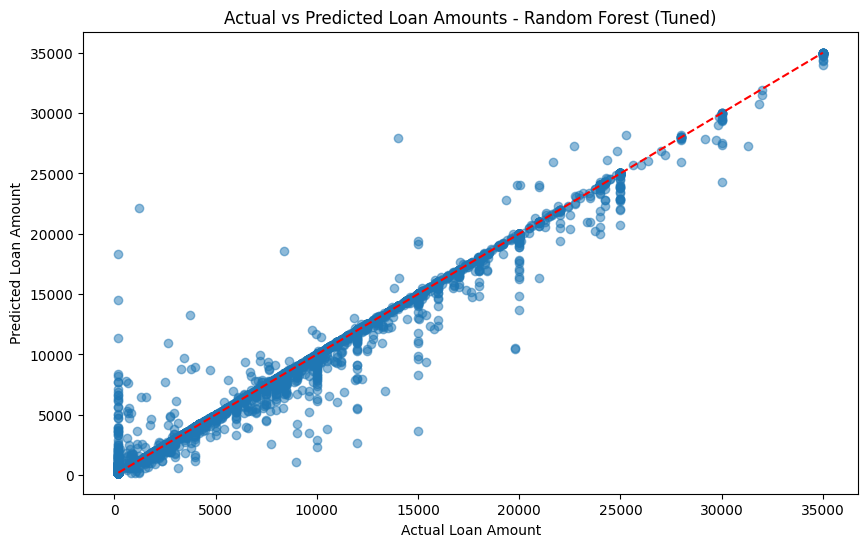

In [78]:
# Evaluate the best model
best_model = grid_search.best_estimator_
result = evaluate_model(best_model, X_test, y_test, f"Random Forest (Tuned)")